In [1]:
#include<TFile.h>
#include<TH1.h>
#include<TMath.h>
#include<math.h>
#include<TF1.h>
#include<TLine.h>
#include<TStyle.h>
#include<TPoint.h>
#include<iostream>
#include<string>
#include<stdio.h>

In [2]:
// Selección de fit:
const Int_t fit = 2; // Opciones: 1: Gauss. 2: Breit Wigner.

In [3]:
void PrintCanvas(TCanvas* c1, string title) {
    string outFolder="Optimization";
    string tpng = outFolder+"/"+title+".png";
    c1->SaveAs(tpng.c_str());

    string tpdf = outFolder+"/"+title+".pdf";
    c1->SaveAs(tpdf.c_str());

    string troot = outFolder+"/"+title+".root";
    c1->SaveAs(troot.c_str());
    
    return;
}

Info in <TCanvas::Print>: png file Optimization/mass_four_lep.png has been created


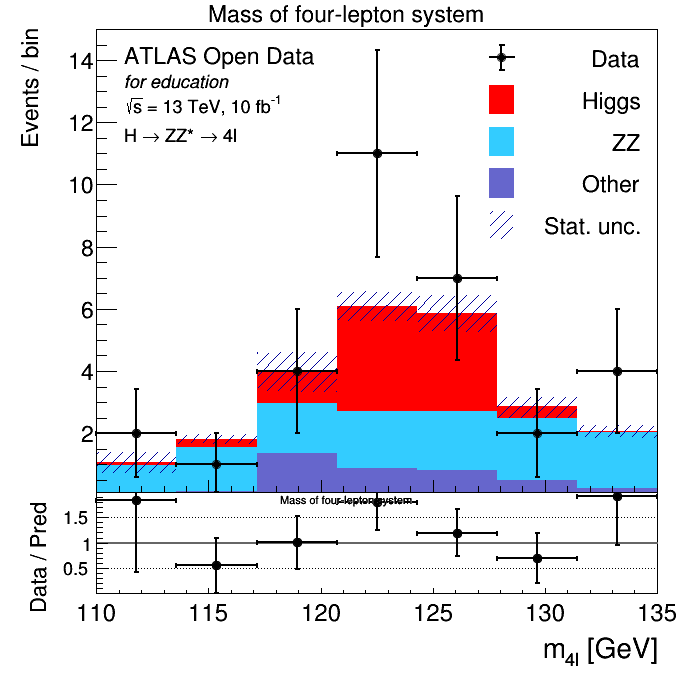

Info in <TCanvas::SaveAs>: ROOT file Optimization/mass_four_lep.root has been created


In [4]:
TFile *f = new TFile("//Plotting/histograms/mass_four_lep.root","READ");
//f->ls();
TH1F * h1 = (TH1F*)f->Get("c");

h1->SaveAs("Optimization/mass_four_lep.png");
h1->SaveAs("Optimization/mass_four_lep.root");

h1->Draw();

In [5]:
//TCanvas *c1 = new TCanvas("c1","c1",900, 600); //este es comodin, por si queremos dibujar algo
TCanvas *c1 = new TCanvas("c1","c1"); //este es comodin, por si queremos dibujar algo
//c1->cd();
c1->SetGrid();
gStyle->SetPaperSize(20,26);
gStyle->SetPadTopMargin(0.05);
gStyle->SetPadRightMargin(0.05); 
gStyle->SetPadBottomMargin(0.16);
gStyle->SetPadLeftMargin(0.16);
gStyle->SetTitleXOffset(1.5);
gStyle->SetTitleYOffset(1.5);
gStyle->SetOptTitle (0/1);
gStyle->SetOptStat("");
gStyle->SetPalette(1); //opcional: cambia la paleta de colores en los plots.

In [6]:
Float_t minVal = 110.0; //Valor mínimo del intervalo.
Float_t maxVal = 135.0; //Valor máximo del intervalo.

In [7]:
/*ofstream fout("//Optimization/output.txt");
for(int i=1;i<=h->GetNbinsX();i++) { 
    for(int j=1;j<=h->GetNbinsY();j++) {
        fout<<h1->GetXaxis()->GetBinCenter(i)<<" "<<h1->GetYaxis()->GetBinCenter(j)<<" "<<h1->GetBinContent(i,j)<<endl;
    }
}
fout.close();*/

In [8]:
/*// obtain the statistical uncertainty
float err;
int nbin = h1->GetNbinsX();
for(int i_bin=0;i_bin<=nbin;i_bin++){
    err = histstack->GetBinError(i_bin);
    histstack->SetBinError(i_bin, err ); 
}*/

In [9]:
Int_t n = 7;
Int_t nbins = 7;
TH1D *data = new TH1D("data","data",n,minVal,maxVal); // Histograma de datos.

// Con 7 bins:
if (n == 7) {  
    data->SetBinContent(1, 1);
    data->SetBinContent(2, 0);
    data->SetBinContent(3, 1);
    data->SetBinContent(4, 8);
    data->SetBinContent(5, 4);
    data->SetBinContent(6, 0);
    data->SetBinContent(7, 2);
}
data->SetName("data");
data->GetXaxis()->SetTitle("m_{4l} [GeV]");
data->GetYaxis()->SetTitle("Events/5 GeV");
data->SetAxisRange(0,11,"y");
data->SetLineColor(kBlack);
data->SetLineWidth(1);
data->SetMarkerStyle(21);
data->SetMarkerSize(1);
data->SetMarkerColor(kBlack);

In [10]:
if (fit == 1) {
    //PDF de la señal, más info: https://root.cern.ch/root/html524/TMath.html#TMath:Gaus
    TF1 *signalModel = new TF1("signalModel","[2]*TMath::Gaus(x,[0],[1],1)",minVal,maxVal);
    signalModel->SetParNames ("mean","sigma","constant"); //nombres de los parámetros
    signalModel->SetParameters(125.0,5.0,1.0); //valores de los parámetros
    //signalModel->FixParameter(0,123.8);
    signalModel->SetLineColor(kRed);
    signalModel->SetLineWidth(2);
}
if (fit == 2) {
    //PDF de la señal, más info: https://root.cern.ch/root/html524/TMath.html#TMath:BreitWigner
    TF1 *signalModel = new TF1("signalModel","[2]*TMath::BreitWigner(x,[0],[1])",minVal,maxVal);
    signalModel->SetParNames("mass","width","constant"); //nombres de los parámetros
    signalModel->SetParameters(125.0,5.0,1.0); //valores de los parámetros
    //signalModel->FixParameter(0,123.8);
    signalModel->SetLineColor(kRed);
    signalModel->SetLineWidth(2);
}

In [11]:
r = data->Fit("signalModel",  "LQS", "", minVal, maxVal); // L: likelihood, Q: quiet, reduce printing, S: save fit result
r->Print("v");
//cout << "Probabilidad de X2= " << TMath::Prob(r->MinFcnValue()) << endl;


****************************************
Minimizer is Minuit / Migrad
MinFCN                    =      3.75641
Chi2                      =      3.69141
NDf                       =            4
Edm                       =  1.49102e-06
NCalls                    =          161
mass                      =       123.63   +/-   0.707787    
width                     =      4.24837   +/-   2.24735     
constant                  =      65.4892   +/-   16.7743     

Covariance Matrix:

            	        mass       width    constant
mass        	     0.50096    -0.68541       2.485
width       	    -0.68541      5.0506     -1.3725
constant    	       2.485     -1.3725      281.38

Correlation Matrix:

            	        mass       width    constant
mass        	           1     -0.4309     0.20931
width       	     -0.4309           1   -0.036409
constant    	     0.20931   -0.036409           1


In [12]:
TGraphErrors *gr = new TGraphErrors(data);
Int_t nPoints = data->GetNbinsX();
for (Int_t i=0; i<nPoints; i++){
    gr->SetPoint(i, data->GetBinCenter(i+data->FindBin(110)), 0); 
}
(TVirtualFitter::GetFitter())->GetConfidenceIntervals(gr,0.68);
gr->SetName("gr");
gr->SetFillColor(3);
data->Draw("E");
gr->Draw("E3");
data->Draw("E1P SAME");

Info in <TCanvas::Print>: png file Optimization/fit.png has been created
Info in <TCanvas::Print>: pdf file Optimization/fit.pdf has been created


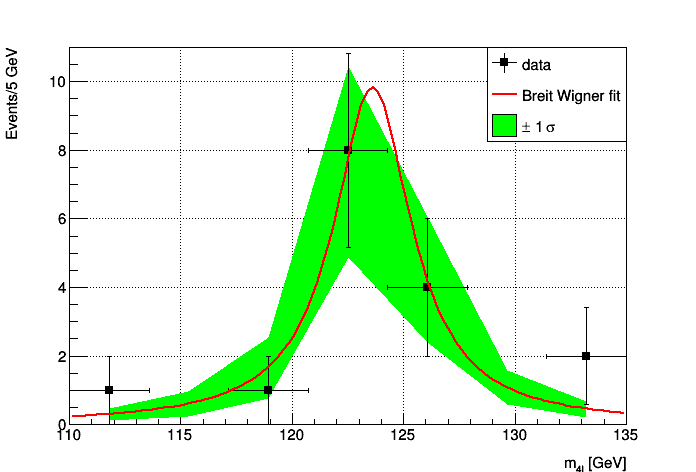

Info in <TCanvas::SaveAs>: ROOT file Optimization/fit.root has been created


In [13]:
//create legend
auto legend = new TLegend(0.7,0.7,0.9,0.9);
legend->AddEntry("data","data","lep");
if (fit == 1) legend->AddEntry(signalModel,"Gaussian fit","L");
if (fit == 2) legend->AddEntry(signalModel,"Breit Wigner fit","L");
legend->AddEntry("gr","#pm 1 #sigma","f");
legend->Draw("SAME");
c1->Draw();
PrintCanvas(c1, "fit"); // Guardar fit en formato PNG, PDF y ROOT.

Primero creamos un histograma bidimensional

In [14]:
Float_t stepMass = 0.5;
Float_t stepWidth = 0.25;
binMass = int((maxVal-minVal)/stepMass);
binWidth = int(10./stepWidth);
L_Plot = new TH2D("L_Plot","L_Plot",binMass,minVal-stepMass/2.0,maxVal-stepMass/2.0,binWidth,0.5,10.5);

//cout << "binMass: " << binMass << endl;
//cout << "binWidth: " << binWidth << endl;

Luego realizamos ajustes fijando tanto la masa como la anchura, de forma que nos permitan obtener el $\chi^{2}$ en función de dichos parámetros. Sin fijarlos, obtendríamos siempre el valor que más se ajuste a los datos (en el mínimo!).  

In [15]:
//this is for the chi2 on the mass and width
L_Plot->Clear();
for (Float_t masses = minVal; masses < maxVal; masses+=stepMass){
    //cout << "Filling: externo mass: "<< masses << ". bin:" << L_Plot->GetXaxis()->FindBin(masses) << endl;
    for (Float_t widths = 0.25; widths < 10.5; widths+=stepWidth){
        //cout << "Filling: interno mass and bin: " << widths << L_Plot->GetYaxis()->FindBin(widths) << endl;
        
        for (Int_t i=0; i<2; i++) signalModel->ReleaseParameter(i);
        signalModel->FixParameter(0,masses);
        signalModel->FixParameter(1,widths);
        r = data->Fit("signalModel","QLS");
        L_Plot->SetBinContent(L_Plot->FindBin(masses,widths),r->MinFcnValue());
    }
}

Info in <TCanvas::Print>: png file Optimization/2D_hyperspace.png has been created


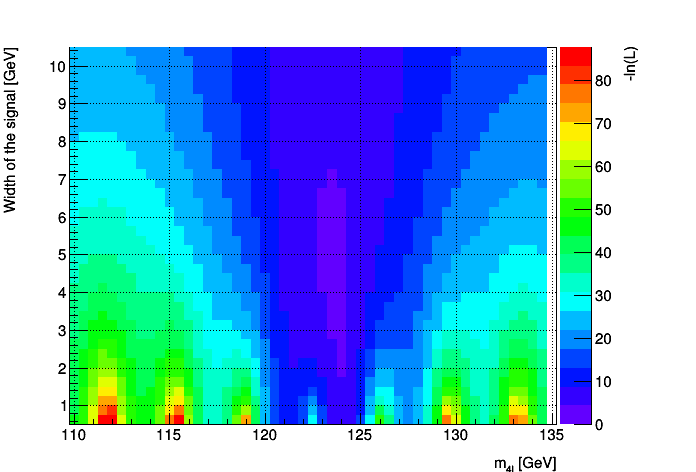

Info in <TCanvas::Print>: pdf file Optimization/2D_hyperspace.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file Optimization/2D_hyperspace.root has been created


In [16]:
//remove borders..
//L_Plot->SetAxisRange(0.5,10,"y");
//L_Plot->SetAxisRange(0,20,"z");
L_Plot->SetAxisRange(110,135,"x");
L_Plot->GetXaxis()->SetTitle("m_{4l} [GeV]");
L_Plot->GetYaxis()->SetTitle("Width of the signal [GeV]");
c1->SetRightMargin(0.2);
L_Plot->GetZaxis()->SetTitle("-ln(L)");
L_Plot->Draw("colz");
gStyle->SetOptStat(000000);
c1->Draw();
PrintCanvas(c1, "2D_hyperspace"); // Guardar 2D_hyperspace en formato PNG, PDF y ROOT.

Info in <TCanvas::Print>: png file Optimization/3D_hyperspace.png has been created


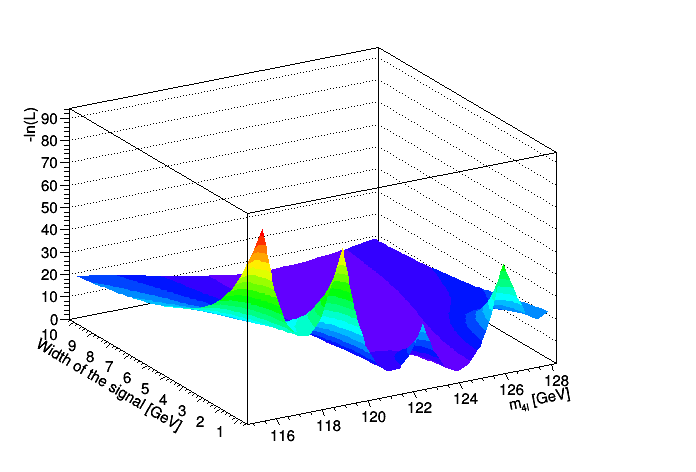

Info in <TCanvas::Print>: pdf file Optimization/3D_hyperspace.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file Optimization/3D_hyperspace.root has been created


In [17]:
// remove borders..
L_Plot->SetAxisRange(0.5,10,"y");
L_Plot->SetAxisRange(115,128,"x");
L_Plot->GetXaxis()->SetTitle("m_{4l} [GeV]");
L_Plot->GetYaxis()->SetTitle("Width of the signal [GeV]");
L_Plot->GetZaxis()->SetTitle("-ln(L)");
L_Plot->Draw("surf2");
gStyle->SetOptStat(000000);
c1->Draw();
PrintCanvas(c1, "3D_hyperspace"); // Guardar 3D_hyperspace en formato PNG, PDF y ROOT.